<a href="https://colab.research.google.com/github/SanketSarmalkar/Tamil_TF_CNN/blob/main/Tamil_TF_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image # image processing
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory # load images from directory
from tensorflow.keras import callbacks # use EarlyStopping
import matplotlib.pyplot as plt
import warnings

2.13.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tamil-hwcr

 77% 39.0M/50.7M [00:00<00:00, 108MB/s]
100% 50.7M/50.7M [00:00<00:00, 125MB/s]


In [ ]:
!ls

kaggle.json  sample_data  tamil-hwcr.zip


In [ ]:
from zipfile import ZipFile
dataset = '/content/tamil-hwcr.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
!ls

kaggle.json  sample_submission.csv  test.csv	 train.csv
sample_data  tamil-hwcr.zip	    Test-Kaggle  Train-Kaggle


In [ ]:
train = pd.read_csv('/content/train.csv')

In [ ]:
test = pd.read_csv('/content/test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62870 entries, 0 to 62869
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           62870 non-null  object
 1   Class Label  62870 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 982.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      28080 non-null  object
dtypes: object(1)
memory usage: 219.5+ KB


In [ ]:
train

,ID,Class Label
0,1.bmp,2
1,2.bmp,3
2,3.bmp,4
3,4.bmp,5
4,5.bmp,6
...,...,...
62865,62866.bmp,152
62866,62867.bmp,153
62867,62868.bmp,154
62868,62869.bmp,155


In [ ]:
width, height = Image.open(
    '/content/Train-Kaggle/Train-Kaggle/1.bmp'
).size
print("Width: ", width, 'Height: ', height)

Width:  64 Height:  64


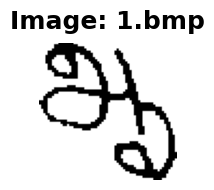

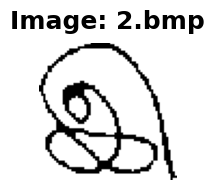

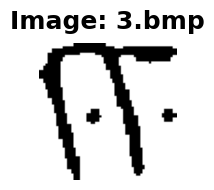

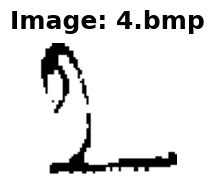

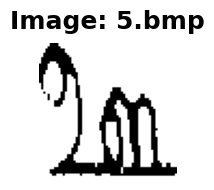

In [ ]:
for i in range(5):
  image_file = train['ID'][i]
  image_path = os.path.join(
      '/content/Train-Kaggle/Train-Kaggle/',
      image_file
  )

  img = Image.open(image_path)

  plt.figure(figsize=(2,2))
  plt.imshow(img)
  plt.title(f'Image: {image_file}')
  plt.axis('off')
  plt.show()

In [ ]:
label = 'Class Label'
num_class = train[label].nunique()
num_class

156

In [ ]:
train[label].describe()

count    62870.000000
mean        77.601861
std         44.977283
min          0.000000
25%         39.000000
50%         78.000000
75%        116.000000
max        155.000000
Name: Class Label, dtype: float64

Text(0.5, 1.0, 'Histogram of Characters')

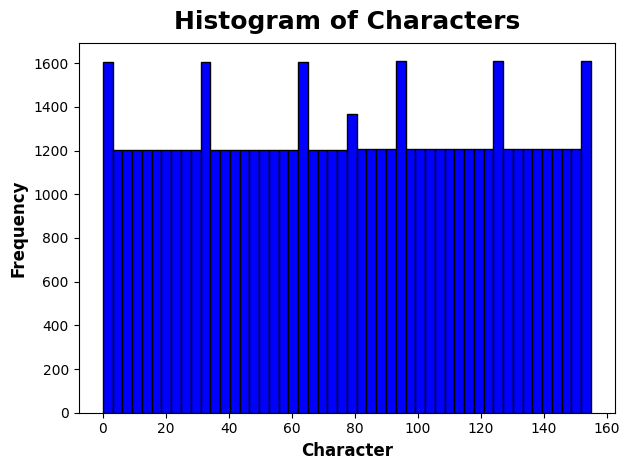

In [ ]:
plt.hist(train[label], bins=50, color='blue', edgecolor='black')


plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Histogram of Characters')

In [ ]:
image_train_directory = '/content/Train-Kaggle/Train-Kaggle/'
image_test_directory = '/content/Test-Kaggle/Test-Kaggle/'

In [ ]:
train = train.sort_values(by='ID')
test = test.sort_values(by='ID')

In [ ]:
# 'Class Label' output values for training set
train_labels = train[label].tolist()

# create the training and validation subsets
train_ds, val_ds = image_dataset_from_directory(
    image_train_directory,
    labels=train_labels,
    label_mode='int',
    validation_split=0.2, # 20% for validation
    subset='both', # return tuple of training and test
    seed=42, # random seed for no overlap of training and validation
    image_size=(64,64), # corresponding image size
    batch_size=32
)
test_ds = image_dataset_from_directory(
    image_test_directory,
    labels=None,
    label_mode=None,
    image_size=(64,64)
)

Found 62870 files belonging to 156 classes.
Using 50296 files for training.
Using 12574 files for validation.
Found 28080 files belonging to 1 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = keras.Sequential([
    # rescale the image to one color channel, but still include input shape with 3 color channel
    layers.Rescaling(1./255, input_shape=(width,height,3)),

    # Convolutional Block
    layers.Conv2D(filters=16,
                  kernel_size=3,
                  activation='relu',
                  padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    # Convolutional Block #2
    layers.Conv2D(filters=32,
                  kernel_size=2,
                  activation='relu',
                  padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),

    # Convolutional Block #3
    layers.Conv2D(filters=64,
                  kernel_size=2,
                  activation='relu',
                  padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
     # Classifier Head
    layers.Flatten(),
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.50),
    # end layer with as many units as possible classes
    layers.Dense(units=num_class, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                   

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    restore_best_weights=True
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/30
1572/1572 [==============================] - 17s 11ms/step - loss: 0.2135 - accuracy: 0.9309 - val_loss: 0.1517 - val_accuracy: 0.9561
Epoch 2/30
1572/1572 [==============================] - 9s 6ms/step - loss: 0.2053 - accuracy: 0.9333 - val_loss: 0.1466 - val_accuracy: 0.9578
Epoch 3/30
1572/1572 [==============================] - 9s 5ms/step - loss: 0.2026 - accuracy: 0.9339 - val_loss: 0.1445 - val_accuracy: 0.9586
Epoch 4/30
1572/1572 [==============================] - 9s 6ms/step - loss: 0.1951 - accuracy: 0.9371 - val_loss: 0.1526 - val_accuracy: 0.9563
Epoch 5/30
1572/1572 [==============================] - 10s 6ms/step - loss: 0.1906 - accuracy: 0.9385 - val_loss: 0.1482 - val_accuracy: 0.9563
Epoch 6/30
1572/1572 [==============================] - 9s 6ms/step - loss: 0.1858 - accuracy: 0.9399 - val_loss: 0.1409 - val_accuracy: 0.9579
Epoch 7/30
1572/1572 [==============================] - 9s 5ms/step - loss: 0.1858 - accuracy: 0.9389 - val_loss: 0.1423 - val_accura

<function matplotlib.pyplot.show(close=None, block=None)>

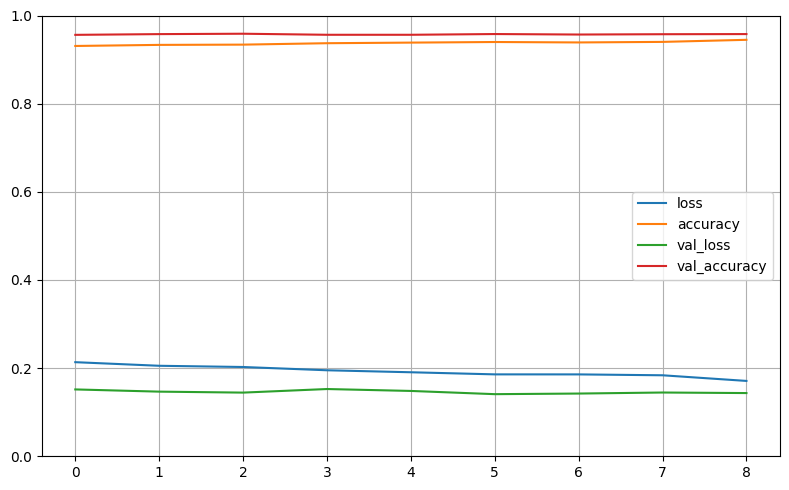

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [ ]:
predictions = model.predict(test_ds)
predictions

878/878 [==============================] - 12s 13ms/step


array([[3.7360010e-08, 3.4930841e-07, 3.6202469e-05, ..., 1.1519608e-05,
        1.4831197e-03, 5.6151621e-04],
       [1.5530642e-07, 7.3411286e-07, 1.3401531e-06, ..., 3.6581915e-09,
        2.8578683e-07, 6.0151854e-07],
       [1.0293862e-25, 2.0097388e-15, 1.7069481e-19, ..., 1.1467084e-18,
        1.9484353e-13, 3.9672109e-13],
       ...,
       [3.7787929e-16, 9.0774632e-13, 2.8370707e-16, ..., 1.0193801e-21,
        2.4024387e-11, 1.2440295e-22],
       [1.8017445e-09, 1.9308676e-16, 3.4155549e-22, ..., 3.3532771e-14,
        1.6499153e-12, 1.0656606e-14],
       [3.0233891e-06, 6.1341324e-13, 1.8818611e-15, ..., 1.3683263e-09,
        1.3678669e-13, 5.6454966e-05]], dtype=float32)

In [ ]:
softmax_predictions = np.argmax(predictions, axis=1)

In [ ]:
submission = pd.DataFrame({'ID': test.ID,'Class Label': softmax_predictions })
submission.to_csv('submission.csv', index=False)
submission = pd.read_csv('submission.csv')
submission

,ID,Class Label
0,1.bmp,9
1,10.bmp,51
2,100.bmp,36
3,1000.bmp,49
4,10000.bmp,62
...,...,...
28075,9995.bmp,147
28076,9996.bmp,140
28077,9997.bmp,20
28078,9998.bmp,69


In [ ]:
import pickle

In [ ]:
file_name = "Tamil_Letter_Recognition_TF_CNN.sav"
pickle.dump(model, open(file_name, "wb"))